# Python Code for Peptide Sequencing of Plasma after Chlorine Exposure

## Import relevant packages

In [1]:
import collections, datetime, itertools, os, re, functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import difflib
from tqdm.auto import tqdm

## Define functions

In [2]:
threshold_area = 1e4

def log_step(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        tic = datetime.datetime.now()
        result = func(*args, **kwargs)
        time_taken = (datetime.datetime.now() - tic).microseconds / 1000
        print(f"just ran step {func.__name__:33} shape={result.shape} took {time_taken:.1f}s")
        return result
    return wrapper

@log_step
def start_pipeline(d): #d = data
    return d.copy()

@log_step
def drop_columns(d, columns):
    return d.drop(columns=columns)

@log_step
def select_tyrosines(d):
    return d.loc[d["Peptide"].str.contains('Y')]

@log_step
def drop_duplicates(d, cols=['Peptide', 'RT'], check_for=['Area']):
    """Drops double peptide entries. Keeps only the entry with the largest Area."""
    d.sort_values('Area', ascending=False) # Sets entries with the largest area first.
    mask = ~d[cols].duplicated()
    mask_check = ~d[cols + check_for].duplicated()
    if sum(mask) != sum(mask_check):
        print(f"!! Multiple entries exist for given {cols} with varying {check_for} columns.")
    return d.loc[mask] # Retain only the first entry for each type of Peptide.

@log_step
def drop_small_areas(d, threshold):
    return d.loc[d['Area'] >= threshold]

@log_step 
def clean_peptide(d):
    d["Peptide_clean"] = (
        d["Peptide"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
        #To get a consistent peptide_clean:
         .str.replace('YKFQNALLVRYTKKVPQVSTPTLVEVSR', 'YKFQNALLVRY') #Automatic processing gives chlorination only at tyrosine in the second part
         .str.replace('PSRDELTKNQVSLTCLVKGFYPSDIAVEWESNGQPENNYK', 'PSRDELTKNQVSLTCLVKGFY') #Automatic processing gives chlorination at wrong tyrosine in the second part
         .str.replace('RPAPPPISGGGYRARPAKAA', 'RPAPPPISGGGY') #Automatic processing does not combine same peptide sites
         .str.replace('EVDETYVPKEF', 'TYVPKEF') #Automatic processing does not combine same peptide sites
    )
    return d

@log_step
def keep_first_accession(d):
    d["Accession"] = d['Accession'].str.split(':').str[0]
    return d

@log_step
def split_accession(d):
    return d.assign(
        Accession_protein=d['Accession'].str.split('|').str[0],
        Accession_specie=d['Accession'].str.split('_').str[1]
    )

@log_step
def select_species(d, selections):
    return d.loc[d['Accession_specie'].isin(selections)]

@log_step
def select_human_accession(d, keep_nan=True):
    accessions = d['Accession'].str.split(':')
    species = d['Accession'].str.split(':').apply(lambda accessions: [accession.split('_')[1] for accession in accessions] if type(accessions) is list else accessions)
    mask_human = species.apply(lambda accessions: 'HUMAN' in accessions if type(accessions) is list else False)
    if keep_nan:
        return d.loc[species.isna() | mask_human]
    else:
        return d.loc[mask_human]

def chlorination(sequence):
    result = dict()
    while sequence.find('(') != -1: #If no bracket is found, -1 is given, which means that there is no chlorination.
        first_chlorinated_aa = sequence.find('(') - 1 #Counts the location of the bracket, starting from zero. Because ( is associated to letter just before, -1 is applied.
        first_digit_after_plus = int(sequence[first_chlorinated_aa + 3]) #The +3 ensures the first digit after the + sign is selected, which is 3 for one chlorine and 6 for two chlorines. 
        assert first_digit_after_plus in [3, 6], f'In chlorination found invalid {first_digit_after_plus=}' #If something is found different than 3 or 6 an error message returns.  
        n_chlorinated = first_digit_after_plus // 3 #This gives one or two for the number of chlorines.  // = floor division, where value is rounded (https://python-reference.readthedocs.io/en/latest/docs/operators/floor_division.html)
        result[first_chlorinated_aa] = n_chlorinated #Result has the following info: d[key] = value, so key=position chlorinated and value=number of chlorine atoms associated to this aa
        before_bracket = sequence[:first_chlorinated_aa+1]
        after_bracket = sequence[first_chlorinated_aa + 9:]
        sequence = before_bracket + after_bracket #This is a loop where the chlorine is discarded that is found before and where is searched for the next chlorine. So the 'sequence' term is overwritten here.
    return result

@log_step
def add_chlorination(d):
    return d.assign(chlorination=lambda x: x['Peptide'].apply(chlorination))

@log_step
def change_name(d):
    return d.rename(columns={'Area Sample 1': 'Area'})

#Every .pipe can be deselected by using # before the row.
def entire_pipeline(sample_file='data/210423-2/Trypsine 0 mM 1 Peaks DB gas peptide.csv'
                   ):
    return (
        pd.read_csv(sample_file) #df = dataframe
        .pipe(start_pipeline)
        .pipe(drop_columns, ['Fraction', 'Source File', '#Feature', 'Scan', 'AScore', '#Feature Sample 1', 'Found By'])
        .pipe(change_name)
        .pipe(select_tyrosines)
        .pipe(drop_duplicates)
        .pipe(drop_small_areas, threshold=threshold_area)
        .pipe(clean_peptide)
        .pipe(select_human_accession, keep_nan=True)
        .pipe(keep_first_accession)
        .pipe(split_accession)
        .pipe(select_species, ['HUMAN'])
        .pipe(add_chlorination)
    )

## Import data and use functions to clean up

In [3]:
df = entire_pipeline()

just ran step start_pipeline                    shape=(926, 17) took 0.1s
just ran step drop_columns                      shape=(926, 10) took 7.4s
just ran step change_name                       shape=(926, 10) took 1.2s
just ran step select_tyrosines                  shape=(269, 10) took 3.4s
just ran step drop_duplicates                   shape=(269, 10) took 6.7s
just ran step drop_small_areas                  shape=(262, 10) took 14.7s
just ran step clean_peptide                     shape=(262, 11) took 4.6s
just ran step select_human_accession            shape=(250, 11) took 4.1s
just ran step keep_first_accession              shape=(250, 11) took 1.2s
just ran step split_accession                   shape=(250, 13) took 3.5s
just ran step select_species                    shape=(217, 13) took 1.7s
just ran step add_chlorination                  shape=(217, 14) took 1.5s


## Data

### Sample results single file

In [4]:
df

,Peptide,-10lgP,Mass,Length,ppm,m/z,RT,Area,Accession,PTM,Peptide_clean,Accession_protein,Accession_specie,chlorination
1,TSESGELHGLTTEEEFVEGIYK,116.91,2454.1438,22,3.5,1228.0835,21.34,2928800.0,P02766|TTHY_HUMAN,NaN,TSESGELHGLTTEEEFVEGIYK,P02766,HUMAN,{}
5,AIQLTYNPDESSKPNMIDAATLK,105.51,2519.2578,23,3.6,1260.6407,20.58,36589000.0,P02679|FIBG_HUMAN,NaN,AIQLTYNPDESSKPNMIDAATLK,P02679,HUMAN,{}
7,LYHSEAFTVNFGDTEEAK,100.81,2056.9377,18,3.5,1029.4797,20.42,37113000.0,P01009|A1AT_HUMAN,NaN,LYHSEAFTVNFGDTEEAK,P01009,HUMAN,{}
10,HQLYIDETVNSNIPTNLR,97.73,2126.0757,18,2.3,1064.0476,20.25,57311000.0,P02675|FIBB_HUMAN,NaN,HQLYIDETVNSNIPTNLR,P02675,HUMAN,{}
11,AHYGGFTVQNEANKYQISVNK,97.31,2367.1606,21,1.8,1184.5897,18.72,1888900.0,P02675|FIBB_HUMAN,NaN,AHYGGFTVQNEANKYQISVNK,P02675,HUMAN,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,YQQKPGKAPK,16.00,1143.6400,10,-32.3,382.2083,14.11,508610.0,P0DOX7|IGK_HUMAN,NaN,YQQKPGKAPK,P0DOX7,HUMAN,{}
907,KKYLYEIAR,15.92,1182.6760,9,-36.7,592.3236,19.95,303570.0,P02768|ALBU_HUMAN,NaN,KKYLYEIAR,P02768,HUMAN,{}
909,YEASILTH,15.81,932.4603,8,2.1,467.2384,18.92,307070.0,P02679|FIBG_HUMAN,NaN,YEASILTH,P02679,HUMAN,{}
915,YVLPNFEVK,15.38,1107.5964,9,3.3,554.8073,21.10,394610.0,P0C0L5|CO4B_HUMAN,NaN,YVLPNFEVK,P0C0L5,HUMAN,{}


### Sample results combined

In [5]:
sample_results = (
    pd.concat(
        [
            entire_pipeline(sample_file=file.path).assign(
                concentration=int(file.name.split(' ')[1]),
                n=int(file.name.split(' ')[3])
            )
            for file in os.scandir('data/210423-2') 
            if file.name.startswith('Trypsine') 
            and 'Peaks DB' in file.name 
        ],
        ignore_index=True
    )
    .assign(chlorine_atoms=lambda x: x['chlorination'].apply(lambda x: sum(x.values())))
)

just ran step start_pipeline                    shape=(926, 17) took 0.1s
just ran step drop_columns                      shape=(926, 10) took 0.7s
just ran step change_name                       shape=(926, 10) took 0.3s
just ran step select_tyrosines                  shape=(269, 10) took 1.7s
just ran step drop_duplicates                   shape=(269, 10) took 4.3s
just ran step drop_small_areas                  shape=(262, 10) took 0.7s
just ran step clean_peptide                     shape=(262, 11) took 2.3s
just ran step select_human_accession            shape=(250, 11) took 2.6s
just ran step keep_first_accession              shape=(250, 11) took 1.0s
just ran step split_accession                   shape=(250, 13) took 2.4s
just ran step select_species                    shape=(217, 13) took 0.8s
just ran step add_chlorination                  shape=(217, 14) took 0.8s
just ran step start_pipeline                    shape=(1265, 17) took 0.1s
just ran step drop_columns           

In [6]:
#sample_results

### Overview chlorination

In [7]:
(
    pd.concat(
        {
           'total Cl': sample_results.groupby(['concentration']).sum()['chlorine_atoms'],
           'total Y': sample_results.assign(y_count=lambda x: x['Peptide'].str.count('Y')).groupby(['concentration'])['y_count'].sum()
        }, 
        axis=1
    )
    .assign(n=[4,3,3,3], 
            TotalClAverage = lambda x: x['total Cl'] / x['n'],
            FractionClY = lambda x: (x['total Cl'] / x['total Y'])*100)
)

,total Cl,total Y,n,TotalClAverage,FractionClY
concentration,,,,,
0,2,1215,4,0.500000,0.164609
7,6,1151,3,2.000000,0.521286
70,24,1025,3,8.000000,2.341463
350,107,659,3,35.666667,16.236722


### Sequence matcher

In [8]:
def get_similarity_score(peptide_a, peptide_b):
    return difflib.SequenceMatcher(None, peptide_a, peptide_b).find_longest_match(alo=0, ahi=len(peptide_a), blo=0, bhi=len(peptide_b))[2]/len(peptide_a)

In [9]:
verbose = True
simplified_results = sample_results.copy()
for a, b in tqdm(list(itertools.combinations([1, 2, 3, 4], r=2))):
    for peptide_a in simplified_results.query(f"(n=={a})")["Peptide_clean"].values:    
        for peptide_b in simplified_results.query(f"(n=={b})")["Peptide_clean"].values:    
            similarity_score = get_similarity_score(peptide_a, peptide_b)
            if similarity_score >= .8: # Replace! #0.8
                if len(peptide_a) < len(peptide_b): # Replace b with a
                    if verbose: print(f'Replace {peptide_b} with {peptide_a}')
                    simplified_results.loc[lambda x: (x['n'] == b) & (x['Peptide_clean'] == peptide_b), 'Peptide_clean'] = peptide_a
                else: # Replace a with b
                    if verbose: print(f'Replace {peptide_a} with {peptide_b}')
                    simplified_results.loc[lambda x: (x['n'] == a) & (x['Peptide_clean'] == peptide_a), 'Peptide_clean'] = peptide_b

  0%|          | 0/6 [00:00<?, ?it/s]

Replace TSESGELHGLTTEEEFVEGIYK with TSESGELHGLTTEEEFVEGIYK
Replace TSESGELHGLTTEEEFVEGIYK with TSESGELHGLTTEEEFVEGIYK
Replace TSESGELHGLTTEEEFVEGIYK with TSESGELHGLTTEEEFVEGIYK
Replace AIQLTYNPDESSKPNMIDAATLK with AIQLTYNPDESSKPNMIDAATLK
Replace AIQLTYNPDESSKPNMIDAATLK with AIQLTYNPDESSKPNMIDAATLK
Replace AIQLTYNPDESSKPNMIDAATLK with AIQLTYNPDESSKPNMIDAATLK
Replace LYHSEAFTVNFGDTEEAK with LYHSEAFTVNFGDTEEAK
Replace LYHSEAFTVNFGDTEEAKK with LYHSEAFTVNFGDTEEAK
Replace LYHSEAFTVNFGDTEEAK with LYHSEAFTVNFGDTEEAK
Replace LYHSEAFTVNFGDTEEAKK with LYHSEAFTVNFGDTEEAK
Replace LYHSEAFTVNFGDTEEAK with LYHSEAFTVNFGDTEEAK
Replace LYHSEAFTVNFGDTEEAKK with LYHSEAFTVNFGDTEEAK
Replace LYHSEAFTVNFGDTEEAK with LYHSEAFTVNFGDTEEAK
Replace LYHSEAFTVNFGDTEEAKK with LYHSEAFTVNFGDTEEAK
Replace HQLYIDETVNSNIPTNLR with HQLYIDETVNSNIPTNLR
Replace HQLYIDETVNSNIPTNLR with HQLYIDETVNSNIPTNLR
Replace HQLYIDETVNSNIPTNLR with HQLYIDETVNSNIPTNLR
Replace AHYGGFTVQNEANKYQISVNK with AHYGGFTVQNEANKYQISVNK
Replace AHYGGFTVQN

In [11]:
#Another iteration was performed with another value for pepsin and trypsin digests

verbose = True
simplified_results_pro = simplified_results.copy()
for a, b in tqdm(list(itertools.combinations([1, 2, 3, 4], r=2))):
    for peptide_a in simplified_results_pro.query(f"(n=={a})")["Peptide_clean"].values:    
        for peptide_b in simplified_results_pro.query(f"(n=={b})")["Peptide_clean"].values:    
            similarity_score = get_similarity_score(peptide_a, peptide_b)
            if similarity_score >= .63: # Replace! Pepsin=0.87, Trypsin=0.63
                if len(peptide_a) < len(peptide_b): # Replace b with a
                    if verbose: print(f'Replace {peptide_b} with {peptide_a}')
                    simplified_results_pro.loc[lambda x: (x['n'] == b) & (x['Peptide_clean'] == peptide_b), 'Peptide_clean'] = peptide_a
                else: # Replace a with b
                    if verbose: print(f'Replace {peptide_a} with {peptide_b}')
                    simplified_results_pro.loc[lambda x: (x['n'] == a) & (x['Peptide_clean'] == peptide_a), 'Peptide_clean'] = peptide_b

  0%|          | 0/6 [00:00<?, ?it/s]

Replace TSESGELHGLTTEEEFVEGIYK with TSESGELHGLTTEEEFVEGIYK
Replace TSESGELHGLTTEEEFVEGIYK with TSESGELHGLTTEEEFVEGIYK
Replace TSESGELHGLTTEEEFVEGIYK with TSESGELHGLTTEEEFVEGIYK
Replace AIQLTYNPDESSKPNMIDAATLK with AIQLTYNPDESSKPN
Replace AIQLTYNPDESSKPNMIDAATLK with AIQLTYNPDESSKPN
Replace AIQLTYNPDESSKPNMIDAATLK with AIQLTYNPDESSKPN
Replace AIQLTYNPDESSKPNMIDAATLK with AIQLTYNPDESSKPN
Replace AIQLTYNPDESSKPNMIDAATLK with AIQLTYNPDESSKPN
Replace AIQLTYNPDESSKPNMIDAATLK with AIQLTYNPDESSKPN
Replace HQLYIDETVNSNIPTNLR with HQLYIDETVNSNIPTNLR
Replace HQLYIDETVNSNIPTNLR with HQLYIDETVNSNIPTNLR
Replace HQLYIDETVNSNIPTNLR with HQLYIDETVNSNIPTNLR
Replace AHYGGFTVQNEANKYQISVNK with AHYGGFTVQNEANK
Replace AHYGGFTVQNEANKYQISVNK with AHYGGFTVQNEANK
Replace AHYGGFTVQNEANKYQISVNK with AHYGGFTVQNEANK
Replace AHYGGFTVQNEANKYQISVNK with AHYGGFTVQNEANK
Replace AHYGGFTVQNEANKYQISVNK with AHYGGFTVQNEANK
Replace AHYGGFTVQNEANKYQISVNK with AHYGGFTVQNEANK
Replace AHYGGFTVQNEANKYQISVNK with AHYGGFTVQNEANK
Re

In [12]:
#simplified_results_pro

### Calculation of chlorination score

In [13]:
#Table with average of repeated measurements

clustered_results = (
    simplified_results_pro
    .groupby(['Peptide_clean', 'concentration', 'chlorine_atoms']).agg({'Area': 'mean'})
    .pivot_table(index=['Peptide_clean', 'concentration'], columns=['chlorine_atoms'], values=['Area'])
    .fillna(0)
)
peptides_with_blank = {peptide_clean for peptide_clean, concentration in clustered_results.index if concentration == 0}
clustered_results_mask = [peptide_clean in peptides_with_blank for peptide_clean, concentration in clustered_results.index]
clustered_results = clustered_results.loc[clustered_results_mask]

clustered_results

Area               
chlorine_atoms                          0    1    2    3
Peptide_clean concentration                             
AAVYHHFISDGVR 0              1.888626e+07  0.0  0.0  0.0
              7              6.106950e+07  0.0  0.0  0.0
              70             4.486867e+07  0.0  0.0  0.0
              350            2.265192e+07  0.0  0.0  0.0
ADGSYAAWLSR   0              1.510700e+06  0.0  0.0  0.0
...                                   ...  ...  ...  ...
YYTYLIMNK     7              1.067100e+07  0.0  0.0  0.0
              70             3.128933e+06  0.0  0.0  0.0
YYWGGQYTWDMAK 0              6.606800e+06  0.0  0.0  0.0
              7              1.555997e+07  0.0  0.0  0.0
              70             4.439233e+06  0.0  0.0  0.0

[921 rows x 4 columns]

In [14]:
max_chlorine_atoms = simplified_results_pro['chlorine_atoms'].max()
def score2(x):
    result = 0
    norm = 0
    for i in range(1, max_chlorine_atoms + 1): 
        result += x[('Area', i)]*i
        norm += x[('Area', i)]
    return result / norm

In [15]:
Percentage = 1 - (clustered_results.reset_index()['Area', 0])/np.sum(clustered_results.reset_index()['Area'], axis=1)

In [16]:
scored_results = clustered_results.reset_index().assign(Percentage = Percentage).assign(score2 = score2)
scored_results

Peptide_clean concentration          Area                 \
chlorine_atoms                                          0    1    2    3   
0               AAVYHHFISDGVR             0  1.888626e+07  0.0  0.0  0.0   
1               AAVYHHFISDGVR             7  6.106950e+07  0.0  0.0  0.0   
2               AAVYHHFISDGVR            70  4.486867e+07  0.0  0.0  0.0   
3               AAVYHHFISDGVR           350  2.265192e+07  0.0  0.0  0.0   
4                 ADGSYAAWLSR             0  1.510700e+06  0.0  0.0  0.0   
..                        ...           ...           ...  ...  ...  ...   
916                 YYTYLIMNK             7  1.067100e+07  0.0  0.0  0.0   
917                 YYTYLIMNK            70  3.128933e+06  0.0  0.0  0.0   
918             YYWGGQYTWDMAK             0  6.606800e+06  0.0  0.0  0.0   
919             YYWGGQYTWDMAK             7  1.555997e+07  0.0  0.0  0.0   
920             YYWGGQYTWDMAK            70  4.439233e+06  0.0  0.0  0.0   

               Percentage score2  
chlorine_atoms                    
0                     0.0    NaN  
1                     0.0    NaN  
2                     0.0    NaN  
3                     0.0    NaN  
4                     0.0    NaN  
..                    ...    ...  
916                   0.0    NaN  
917                   0.0    NaN  
918                   0.0    NaN  
919                   0.0    NaN  
920                   0.0    NaN  

[921 rows x 8 columns]

In [17]:
heatmap_data1 = (
    scored_results
    .drop(columns='Area')
    .drop(columns='score2')
    .reset_index()
    .pivot(index=['Peptide_clean'], columns=['concentration'], values=['Percentage'])
    .fillna(0)
    .loc[lambda x: x.loc[:, ('Percentage', 350)] > x.loc[:, ('Percentage', 0)]] #Score of highest concentrations should be higher than the score of the lowest concentration
    .loc[lambda x: x.sum(axis=1) > 0] #Not all scores should be zero
    .sort_values(('Percentage', 350), ascending=False)
)
heatmap_data1

/home/mirjam/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Percentage                         
concentration             0    7         70        350
Peptide_clean                                         
YLQEIYNSNNQK              0.0  0.0  0.000000  1.000000
ATVLNYLPK                 0.0  0.0  0.005738  1.000000
YQQHPGKAPK                0.0  0.0  0.000000  1.000000
LGEVNTYAGDLQK             0.0  0.0  0.000000  1.000000
GVALHRPDVY                0.0  0.0  0.000000  1.000000
YQQKPGKAPK                0.0  0.0  0.000000  0.722541
LINDYVK                   0.0  0.0  0.108756  0.703173
GYTQQLAFR                 0.0  0.0  0.000000  0.574986
VDETYVPK                  0.0  0.0  0.000000  0.559913
YQQKPGQAPR                0.0  0.0  0.178476  0.486118
TAQEGDHGSHVY              0.0  0.0  0.000000  0.356523
HYEGSTVPEK                0.0  0.0  0.058532  0.353173
WYVDGVEVH                 0.0  0.0  0.006962  0.342214
YAPELLFFAK                0.0  0.0  0.000000  0.338994
YVGGQEHFAH                0.0  0.0  0.000000  0.326390
GLSVYADKPETTK             0.0  0.0  0.000000  0.233676
YLYEIAR                   0.0  0.0  0.015537  0.220428
SYSTTAVVTNPK              0.0  0.0  0.000000  0.186583
PAPPPISGGGYR              0.0  0.0  0.000000  0.178657
NSLFEYQK                  0.0  0.0  0.000000  0.167488
AVRPGYPK                  0.0  0.0  0.044819  0.145302
GGSTSYGTGSETESPR          0.0  0.0  0.000000  0.144188
HGPGLIYR                  0.0  0.0  0.000000  0.141768
GEVPPRYPR                 0.0  0.0  0.000000  0.137486
ALSHAVNNYHK               0.0  0.0  0.000000  0.135790
ASAGLLGAHAAAITAY          0.0  0.0  0.000000  0.122395
HQLYIDETVNSNIPTNLR        0.0  0.0  0.000000  0.121919
TYETTLEK                  0.0  0.0  0.013931  0.116339
FSVVYAK                   0.0  0.0  0.000000  0.106968
YAATSQVLLPSK              0.0  0.0  0.000000  0.101084
IQPDSSVKPYR               0.0  0.0  0.000000  0.099846
YTFELSR                   0.0  0.0  0.000000  0.089497
YKPGQTVK                  0.0  0.0  0.009000  0.082124
VGPEADKYR                 0.0  0.0  0.000000  0.079459
LLIYGASTR                 0.0  0.0  0.000000  0.072192
YGAATFTR                  0.0  0.0  0.000000  0.070109
AHYGGFTVQNEANK            0.0  0.0  0.000000  0.064300
YEKPGSPPR                 0.0  0.0  0.000000  0.057403
DDLYVSDAFHK               0.0  0.0  0.000000  0.053730
IYGNQDTSSQLK              0.0  0.0  0.000000  0.038168
AIGYLNTGYQR               0.0  0.0  0.000000  0.030380
HPDYSVVL                  0.0  0.0  0.000000  0.006804

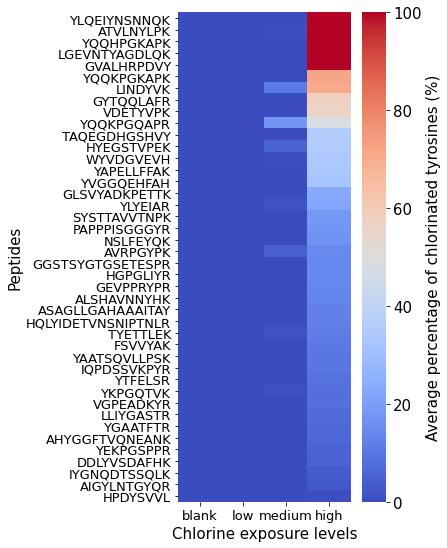

In [26]:
plt.figure(figsize=(6, 10)) #Pepsin: 6,6, Tryspin: 6,10

ax = sns.heatmap(
    data=(heatmap_data1*100).dropna().T.reset_index([None], drop=True).T, 
    cbar_kws={'label': 'Average percentage of chlorinated tyrosines (%)'}, cmap="coolwarm", )

plt.xlabel("Chlorine exposure levels", fontsize = 15)
plt.ylabel("Peptides", fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13, rotation=0)
labels = ['blank', 'low', 'medium', 'high']
ax.set_xticklabels(labels, fontsize = 13)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].tick_params(labelsize=15)
ax.get_yticklabels()

#plt.gcf().subplots_adjust(bottom=0.2, left = 0.4) #Pepsin
plt.gcf().subplots_adjust(bottom=0.2, left = 0.4, right = 0.9) #Trypsin

#plt.savefig('img/Heatmap_Pepsin_Percentage_all.png') # Save image.

In [19]:
heatmap_data2 = (
    scored_results
    .drop(columns='Area')
    .drop(columns='Percentage')
    .reset_index()
    .pivot(index=['Peptide_clean'], columns=['concentration'], values=['score2'])
    .fillna(0)
    .loc[lambda x: x.loc[:, ('score2', 350)] > x.loc[:, ('score2', 0)]] #Score of highest concentrations should be higher than the score of the lowest concentration
    .loc[lambda x: x.sum(axis=1) > 0] #Not all scores should be zero
    .sort_values(('score2', 350), ascending=False)
#    .drop(columns=('score2', 0))
#    .drop(columns=('score2', 7))
)
heatmap_data2

/home/mirjam/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


score2                         
concentration         0    7         70        350
Peptide_clean                                     
YQQKPGKAPK            0.0  0.0  0.000000  2.000000
YLYEIAR               0.0  0.0  1.221499  1.325876
HYEGSTVPEK            0.0  0.0  1.000000  1.019246
AHYGGFTVQNEANK        0.0  0.0  0.000000  1.000000
YAATSQVLLPSK          0.0  0.0  0.000000  1.000000
SYSTTAVVTNPK          0.0  0.0  0.000000  1.000000
TAQEGDHGSHVY          0.0  0.0  0.000000  1.000000
TYETTLEK              0.0  0.0  1.000000  1.000000
VDETYVPK              0.0  0.0  0.000000  1.000000
VGPEADKYR             0.0  0.0  0.000000  1.000000
WYVDGVEVH             0.0  0.0  1.000000  1.000000
YEKPGSPPR             0.0  0.0  0.000000  1.000000
YAPELLFFAK            0.0  0.0  0.000000  1.000000
NSLFEYQK              0.0  0.0  0.000000  1.000000
YGAATFTR              0.0  0.0  0.000000  1.000000
YKPGQTVK              0.0  0.0  1.000000  1.000000
YLQEIYNSNNQK          0.0  0.0  0.000000  1.000000
YQQHPGKAPK            0.0  0.0  0.000000  1.000000
YQQKPGQAPR            0.0  0.0  1.000000  1.000000
YTFELSR               0.0  0.0  0.000000  1.000000
PAPPPISGGGYR          0.0  0.0  0.000000  1.000000
LLIYGASTR             0.0  0.0  0.000000  1.000000
AIGYLNTGYQR           0.0  0.0  0.000000  1.000000
LINDYVK               0.0  0.0  1.000000  1.000000
ALSHAVNNYHK           0.0  0.0  0.000000  1.000000
ASAGLLGAHAAAITAY      0.0  0.0  0.000000  1.000000
ATVLNYLPK             0.0  0.0  1.000000  1.000000
AVRPGYPK              0.0  0.0  1.000000  1.000000
DDLYVSDAFHK           0.0  0.0  0.000000  1.000000
FSVVYAK               0.0  0.0  0.000000  1.000000
GEVPPRYPR             0.0  0.0  0.000000  1.000000
GGSTSYGTGSETESPR      0.0  0.0  0.000000  1.000000
GLSVYADKPETTK         0.0  0.0  0.000000  1.000000
GVALHRPDVY            0.0  0.0  0.000000  1.000000
GYTQQLAFR             0.0  0.0  0.000000  1.000000
HGPGLIYR              0.0  0.0  0.000000  1.000000
HPDYSVVL              0.0  0.0  0.000000  1.000000
HQLYIDETVNSNIPTNLR    0.0  0.0  0.000000  1.000000
IQPDSSVKPYR           0.0  0.0  0.000000  1.000000
IYGNQDTSSQLK          0.0  0.0  0.000000  1.000000
LGEVNTYAGDLQK         0.0  0.0  0.000000  1.000000
YVGGQEHFAH            0.0  0.0  0.000000  1.000000

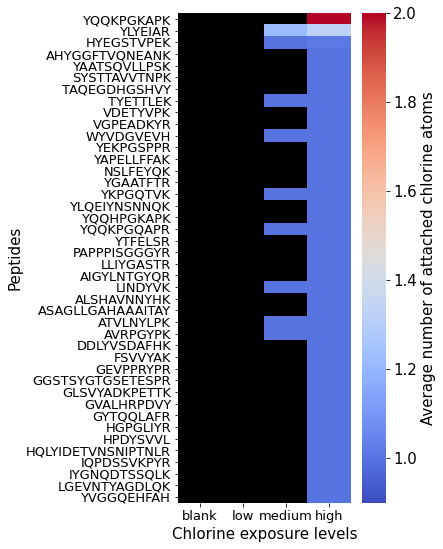

In [28]:
plt.figure(figsize=(6, 10)) #Pepsin: 3,6, Tryspin: 6,10
data = (heatmap_data2).dropna().T.reset_index([None], drop=True).T.replace(0, np.nan)
ax = sns.heatmap(data=data, cbar_kws={'label': 'Average number of attached chlorine atoms'}, cmap="coolwarm", vmin=0.9)
ax.set_facecolor('black')

plt.xlabel("Chlorine exposure levels", fontsize = 15)
plt.ylabel("Peptides", fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13, rotation=0)
labels = ['blank', 'low', 'medium', 'high']
ax.set_xticklabels(labels, fontsize = 13)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].tick_params(labelsize=15)
ax.get_yticklabels()

#plt.gcf().subplots_adjust(bottom=0.2, left = 0.4) #Pepsin
plt.gcf().subplots_adjust(bottom=0.2, left = 0.4, right = 0.9) #Trypsin

#plt.savefig('img/Heatmap_Pepsin_score_v2_all.png') # Save image.

### Comparison protein database

In [21]:
database = pd.read_csv('data/Blood_proteins.csv', sep = ';')
#database

In [22]:
def get_matches(string: str, database: pd.DataFrame):
    if (database['long_sequence'].str.count(string) > 2).any(): #Multiple matches are not expected, but if there are some, a message is shown.
        print(f'Somewhere in the database the peptide {string} has multiple occurences within one protein')
    match = database['long_sequence'].str.find(string)
    if sum(match > 0) == 0:
        return {}
    elif sum(match > 1) == 0:
        raise Exception(f"Found multiple proteins in database that match for {string}")
    else:
        match = match[match > -1]
        match_entry = match.index.values[0]
        match_position = match.values[0]
        result = database.loc[match_entry]
        return {'match position': match_position, 'Accession': result['Accession'], 'Protein': result['Protein']}

In [23]:
g = pd.DataFrame({peptide: get_matches(peptide, database) for peptide in heatmap_data1.index}).T.dropna()
g

,match position,Accession,Protein
YLQEIYNSNNQK,134,P02679|FIBG_HUMAN,Fibrinogen gamma chain
ATVLNYLPK,810,P01023|A2MG_HUMAN,Alpha-2-macroglobulin
YQQHPGKAPK,56,P01704|LV214_HUMAN,Immunoglobulin lambda variable 2-14
LGEVNTYAGDLQK,65,P06727|APOA4_HUMAN,Apolipoprotein A-IV
GVALHRPDVY,322,P01871|IGHM_HUMAN,Immunoglobulin heavy constant mu
YQQKPGKAPK,55,A0A0C4DH67|KV108_HUMAN,Immunoglobulin kappa variable 1-8
LINDYVK,178,P01011|AACT_HUMAN,Alpha-1-antichymotrypsin
GYTQQLAFR,1051,P01024|CO3_HUMAN,Complement C3
VDETYVPK,516,P02768|ALBU_HUMAN,Albumin
YQQKPGQAPR,56,P01619|KV320_HUMAN,Immunoglobulin kappa variable 3-20


In [24]:
h = pd.DataFrame({peptide: get_matches(peptide, database) for peptide in heatmap_data1.index}).T.dropna()['Protein'].value_counts()
h

Albumin                                         5
Alpha-2-macroglobulin                           5
Fibrinogen beta chain                           4
Alpha-2-HS-glycoprotein                         2
Fibrinogen gamma chain                          2
Fibrinogen alpha chain                          2
Immunoglobulin heavy constant mu                2
Alpha-1-acid glycoprotein 1                     2
Fibronectin                                     1
Immunoglobulin kappa variable 3-20              1
Transthyretin                                   1
Immunoglobulin lambda variable 2-14             1
Complement C3                                   1
Vitamin D-binding protein                       1
Antithrombin-III                                1
Immunoglobulin heavy constant gamma 1           1
Complement C4-A                                 1
Hemopexin                                       1
Inter-alpha-trypsin inhibitor heavy chain H2    1
Immunoglobulin kappa variable 1-8               1
